# Class-$c_s^2$ demos

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import interp1d, interp2d
import matplotlib.pyplot as plt

from classy import Class

In [2]:
# Fixed cosmological parameters and accuracy settings
h_ref         = 0.67
Om_ref        = 0.32
Ob_ref        = 0.049
As_ref        = 2.1e-09
ns_ref        = 0.96
wDE_ref       = -1.0
k_per_decade  = 35
z_max_pk      = 200
P_k_max_h_Mpc = 1.0

In [3]:
# Just standard LambdaCDM
cosmo_ref = Class()
cosmo_ref.set(
  {
    'output'       : 'mPk',
    'h'            : h_ref,
    'Omega_cdm'    : Om_ref - Ob_ref,
    'Omega_b'      : Ob_ref,
    'Omega_Lambda' : 0,               # NOTE: this is required to use fluid DE
    'w0_fld'       : '-1.',
    'wa_fld'       : '0.',
    'A_s'          : As_ref,
    'n_s'          : ns_ref,
    'P_k_max_h/Mpc': P_k_max_h_Mpc,
    'z_pk'         : '0.0, 1.0, 2.0',
    'evolver'      : 0,
  }
)
cosmo_ref.compute()

In [4]:
bg_ref = cosmo_ref.get_background()
z = bg_ref['z']
a = 1./(1.+z)
chi = bg_ref['comov. dist.']
z_of_chi = interp1d(chi, z)
chi_of_z = interp1d(z, chi)

In [5]:
wlog10a_vals = np.concatenate((np.array([-14, -3.5]), np.linspace(-3., 0, 8)))
w_vals       = np.concatenate((np.array([-1., -1.]),  np.random.uniform(-2, -0.5, 8)))

def as_class_str(l: list): return ','.join(map(str, l))
as_class_str(w_vals)

'-1.0,-1.0,-1.1382058497405532,-0.6830104364124479,-0.656529028852125,-1.0950550466885633,-1.1251425174515104,-1.685815543506149,-0.5603441903250885,-0.7125042203310457'

In [6]:
# Spline cosmology with cs2 = 1
cosmo_var = Class()
cosmo_var.set(
  {
    'output'      : 'mPk',
    'h'           : h_ref,
    'Omega_Lambda': 0,   # NOTE: this is required to use the spline DE
    'Omega_fld'   : 0,   # NOTE: this is required to use the spline DE
    'Omega_wspl'  : -1,  # NOTE: this is required to use the spline DE
    'Omega_b'     : Ob_ref,
    'Omega_cdm'   : Om_ref - Ob_ref,
    'A_s'         : As_ref,
    'n_s'         : ns_ref,
    'use_ppf'     : 'yes',
    'wlog10a_vals': as_class_str(wlog10a_vals),
    'w_vals'      : as_class_str(w_vals),
    'z_pk'        : '0., 0.5',
    'evolver'     : 0,
  }
)
cosmo_var.compute()
bg_var = cosmo_var.get_background()

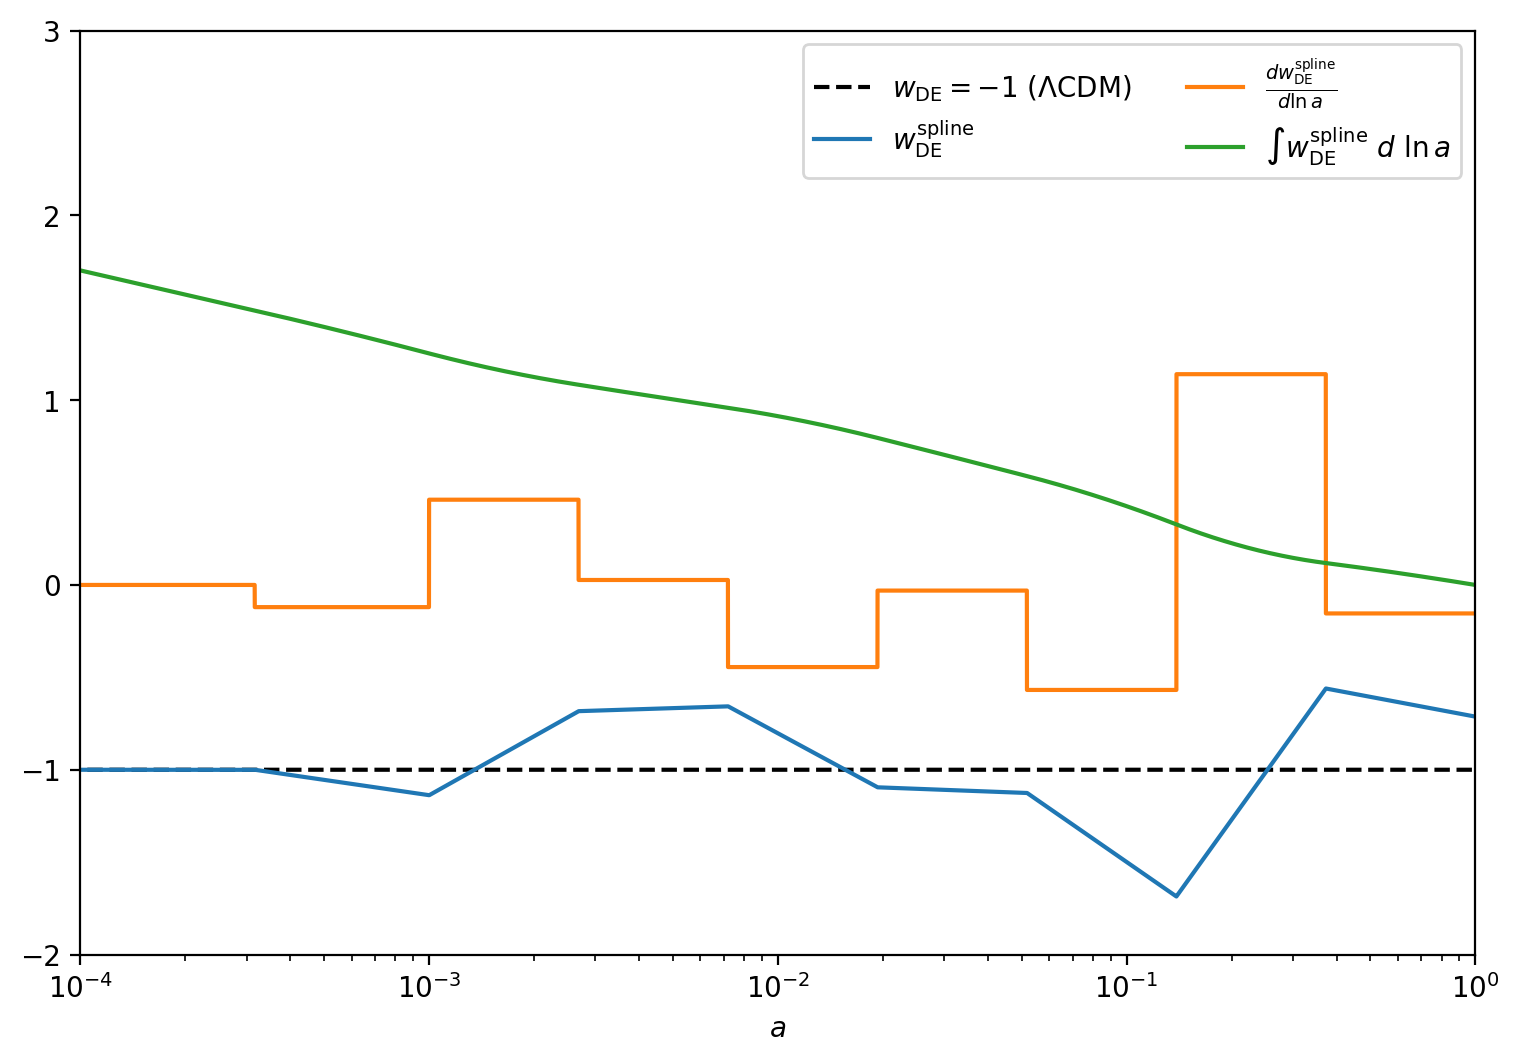

In [7]:
plt.figure(figsize=(9,6))

plt.semilogx(a, -1*np.ones_like(a), '--', color='black', label=r'$w_{\rm DE}=-1$ ($\Lambda$CDM)')
plt.semilogx(a, bg_var['wspl'], label=r'$w_{\rm DE}^{\rm spline}$')
plt.semilogx(a, bg_var['dwspl_dlna'], label=r'$\frac{d w_{\rm DE}^{\rm spline}}{d \ln a}$')
plt.semilogx(a, bg_var['int_wspl_dlna'], label=r'$\int w^{\rm spline}_{\rm DE}~ d~ \ln a$')
plt.xlim(1e-4, 1)
plt.ylim(-2, 3)
plt.xlabel(r'$a$')
plt.legend(ncol=2)

In [8]:
# Now with cs2 relations
cosmo_var2 = Class()
cosmo_var2.set(
  {
    'output'      : 'mPk',
    'h'           : h_ref,
    'Omega_b'     : Ob_ref,
    'Omega_cdm'   : Om_ref - Ob_ref,
    'Omega_Lambda': 0.,
    'Omega_fld'   : 0.,
    'Omega_wspl'  : -1,
    'wlog10a_vals': as_class_str(wlog10a_vals),
    'w_vals'      : as_class_str(w_vals),
    'cs2_0'       : -0.4e-1,
    'cs2_1'       : 2e-3,
    'use_ppf'     : 'yes',
    'A_s'         : As_ref,
    'n_s'         : ns_ref,
    'evolver'     : 0,
  }
)
cosmo_var2.compute()
bg_var2 = cosmo_var2.get_background()

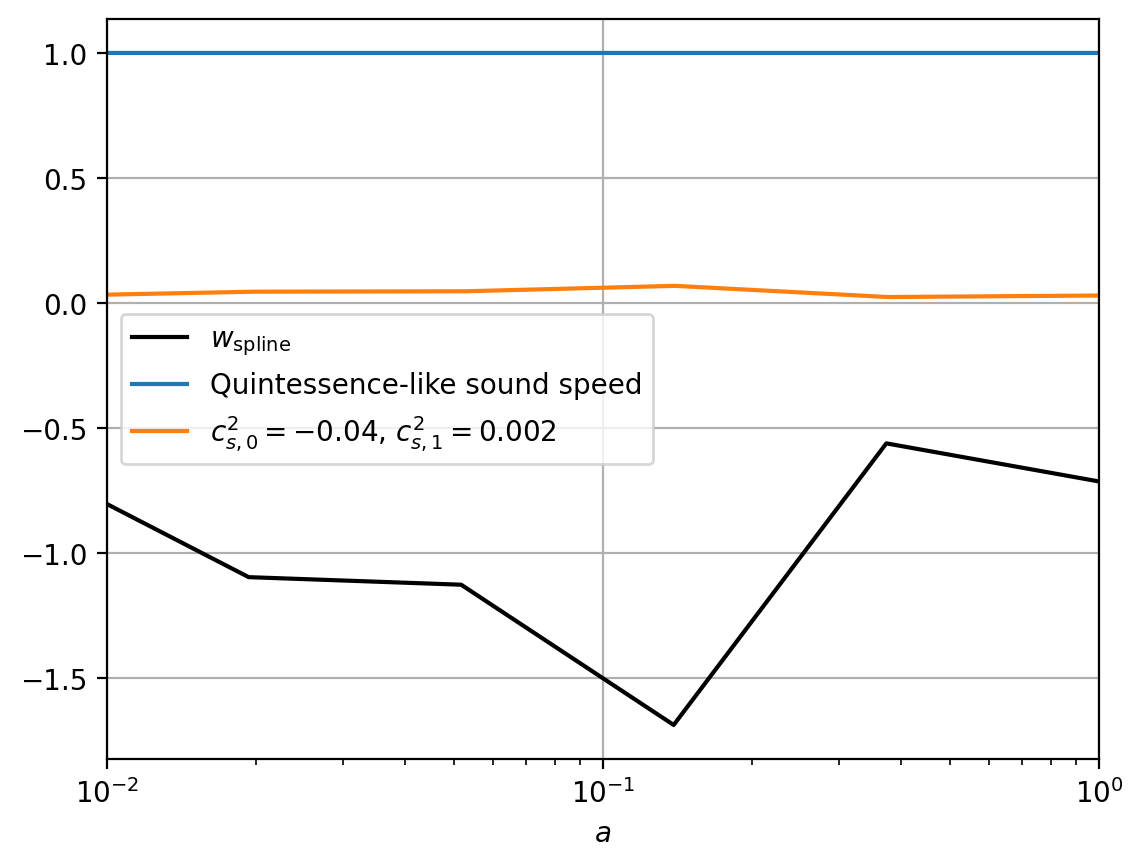

In [9]:
plt.semilogx(a, bg_var['wspl'], color='k', label=r"$w_\mathrm{spline}$")
plt.semilogx(a, bg_var['cs2_wspl'], label="Quintessence-like sound speed")
plt.semilogx(a, bg_var2['cs2_wspl'], label=r"$c^2_{s,0} = -0.04$, $c^2_{s,1} = 0.002$")

plt.xlim(1e-2, 1)
plt.xlabel(r"$a$")
plt.legend()
plt.grid()

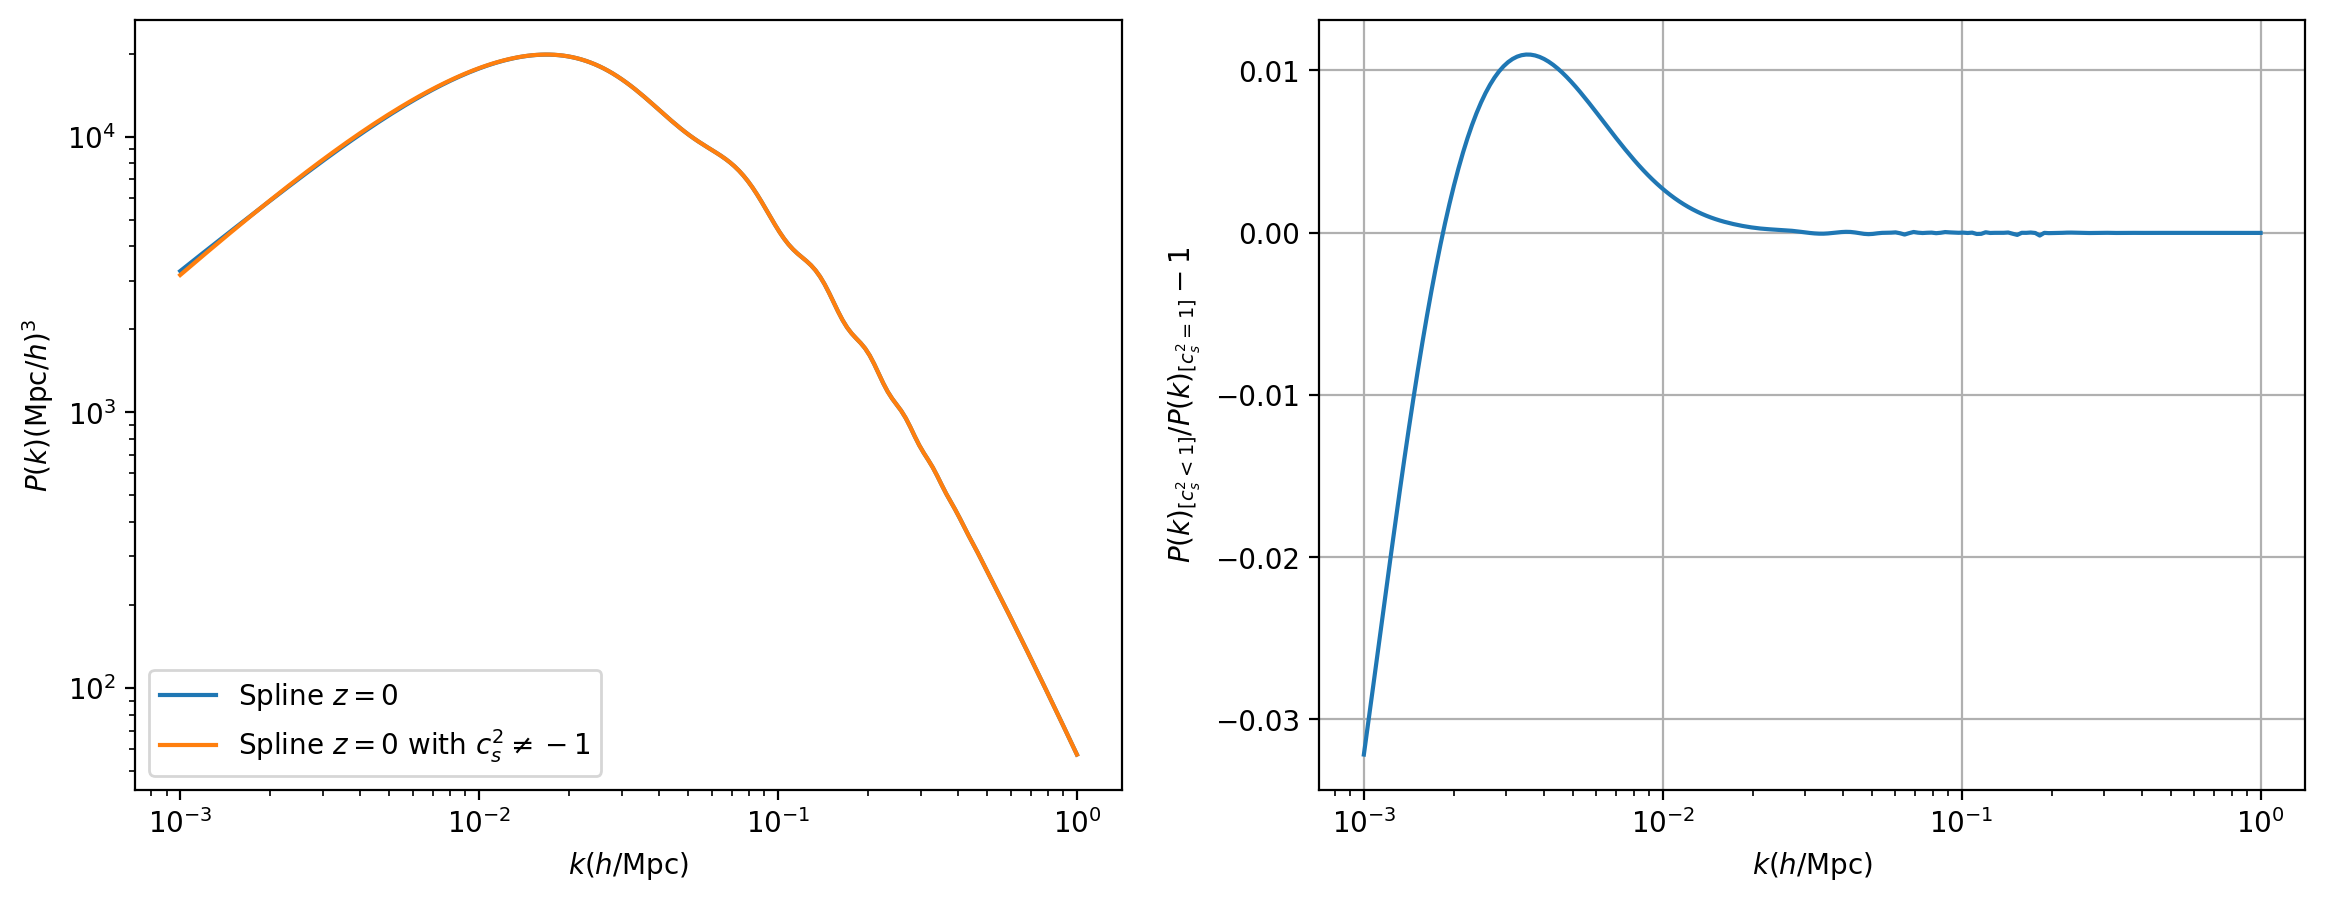

In [10]:
kk = np.logspace(-3, 0, 200) # k in h/Mpc

def pk_h_Mpc_inv(cosmo, k, z):
    h = cosmo.h()
    return cosmo.pk(k*h, z)*h**3

Pk_0_lcdm  = np.array([pk_h_Mpc_inv(cosmo_ref, k, 0) for k in kk])
Pk_0_spl   = np.array([pk_h_Mpc_inv(cosmo_var, k, 0) for k in kk])
Pk_0_spl2  = np.array([pk_h_Mpc_inv(cosmo_var2, k, 0) for k in kk])

fig, axs = plt.subplots(1, 2, figsize=(7*2,5), sharex=True)
axs[0].loglog(kk, Pk_0_spl,  label=r"Spline $z = 0$")
axs[0].loglog(kk, Pk_0_spl2,  label=r"Spline $z = 0$ with $c_s^2 \neq -1$")
axs[0].set_xlabel(r"$k (h/\mathrm{Mpc})$")
axs[0].set_ylabel(r"$P(k) (\mathrm{Mpc}/h)^3$")
axs[0].legend()

axs[1].semilogx(kk, Pk_0_spl2/Pk_0_spl - 1)
axs[1].set_xlabel(r"$k (h/\mathrm{Mpc})$")
axs[1].set_ylabel(r"$P(k)_{[c_s^2 < 1]}/P(k)_{[c_s^2 = 1]} - 1$")
plt.grid()

In [11]:
# w0wa with cs2 relations
cosmo_var3 = Class()
cosmo_var3.set(
  {
    'output'       : 'mPk, dTk, vTk',
    'h'            : h_ref,
    'Omega_b'      : Ob_ref,
    'Omega_cdm'    : Om_ref - Ob_ref,
    'Omega_Lambda' : 0,
    'w0_fld'       : '-0.8',
    'wa_fld'       : '-0.1',
    'use_ppf'      : 'no',
    'cs2_fld_0'    : 1.0,
    'cs2_fld_1'    : 0,
    'A_s'          : As_ref,
    'n_s'          : ns_ref,
    'P_k_max_h/Mpc': P_k_max_h_Mpc,
    'z_pk'         : '0.0, 1.0, 2.0',
    'evolver'      : 0,
  }
)
cosmo_var3.compute()
bg_var3 = cosmo_var3.get_background()

Text(0.5, 0, '$z$')

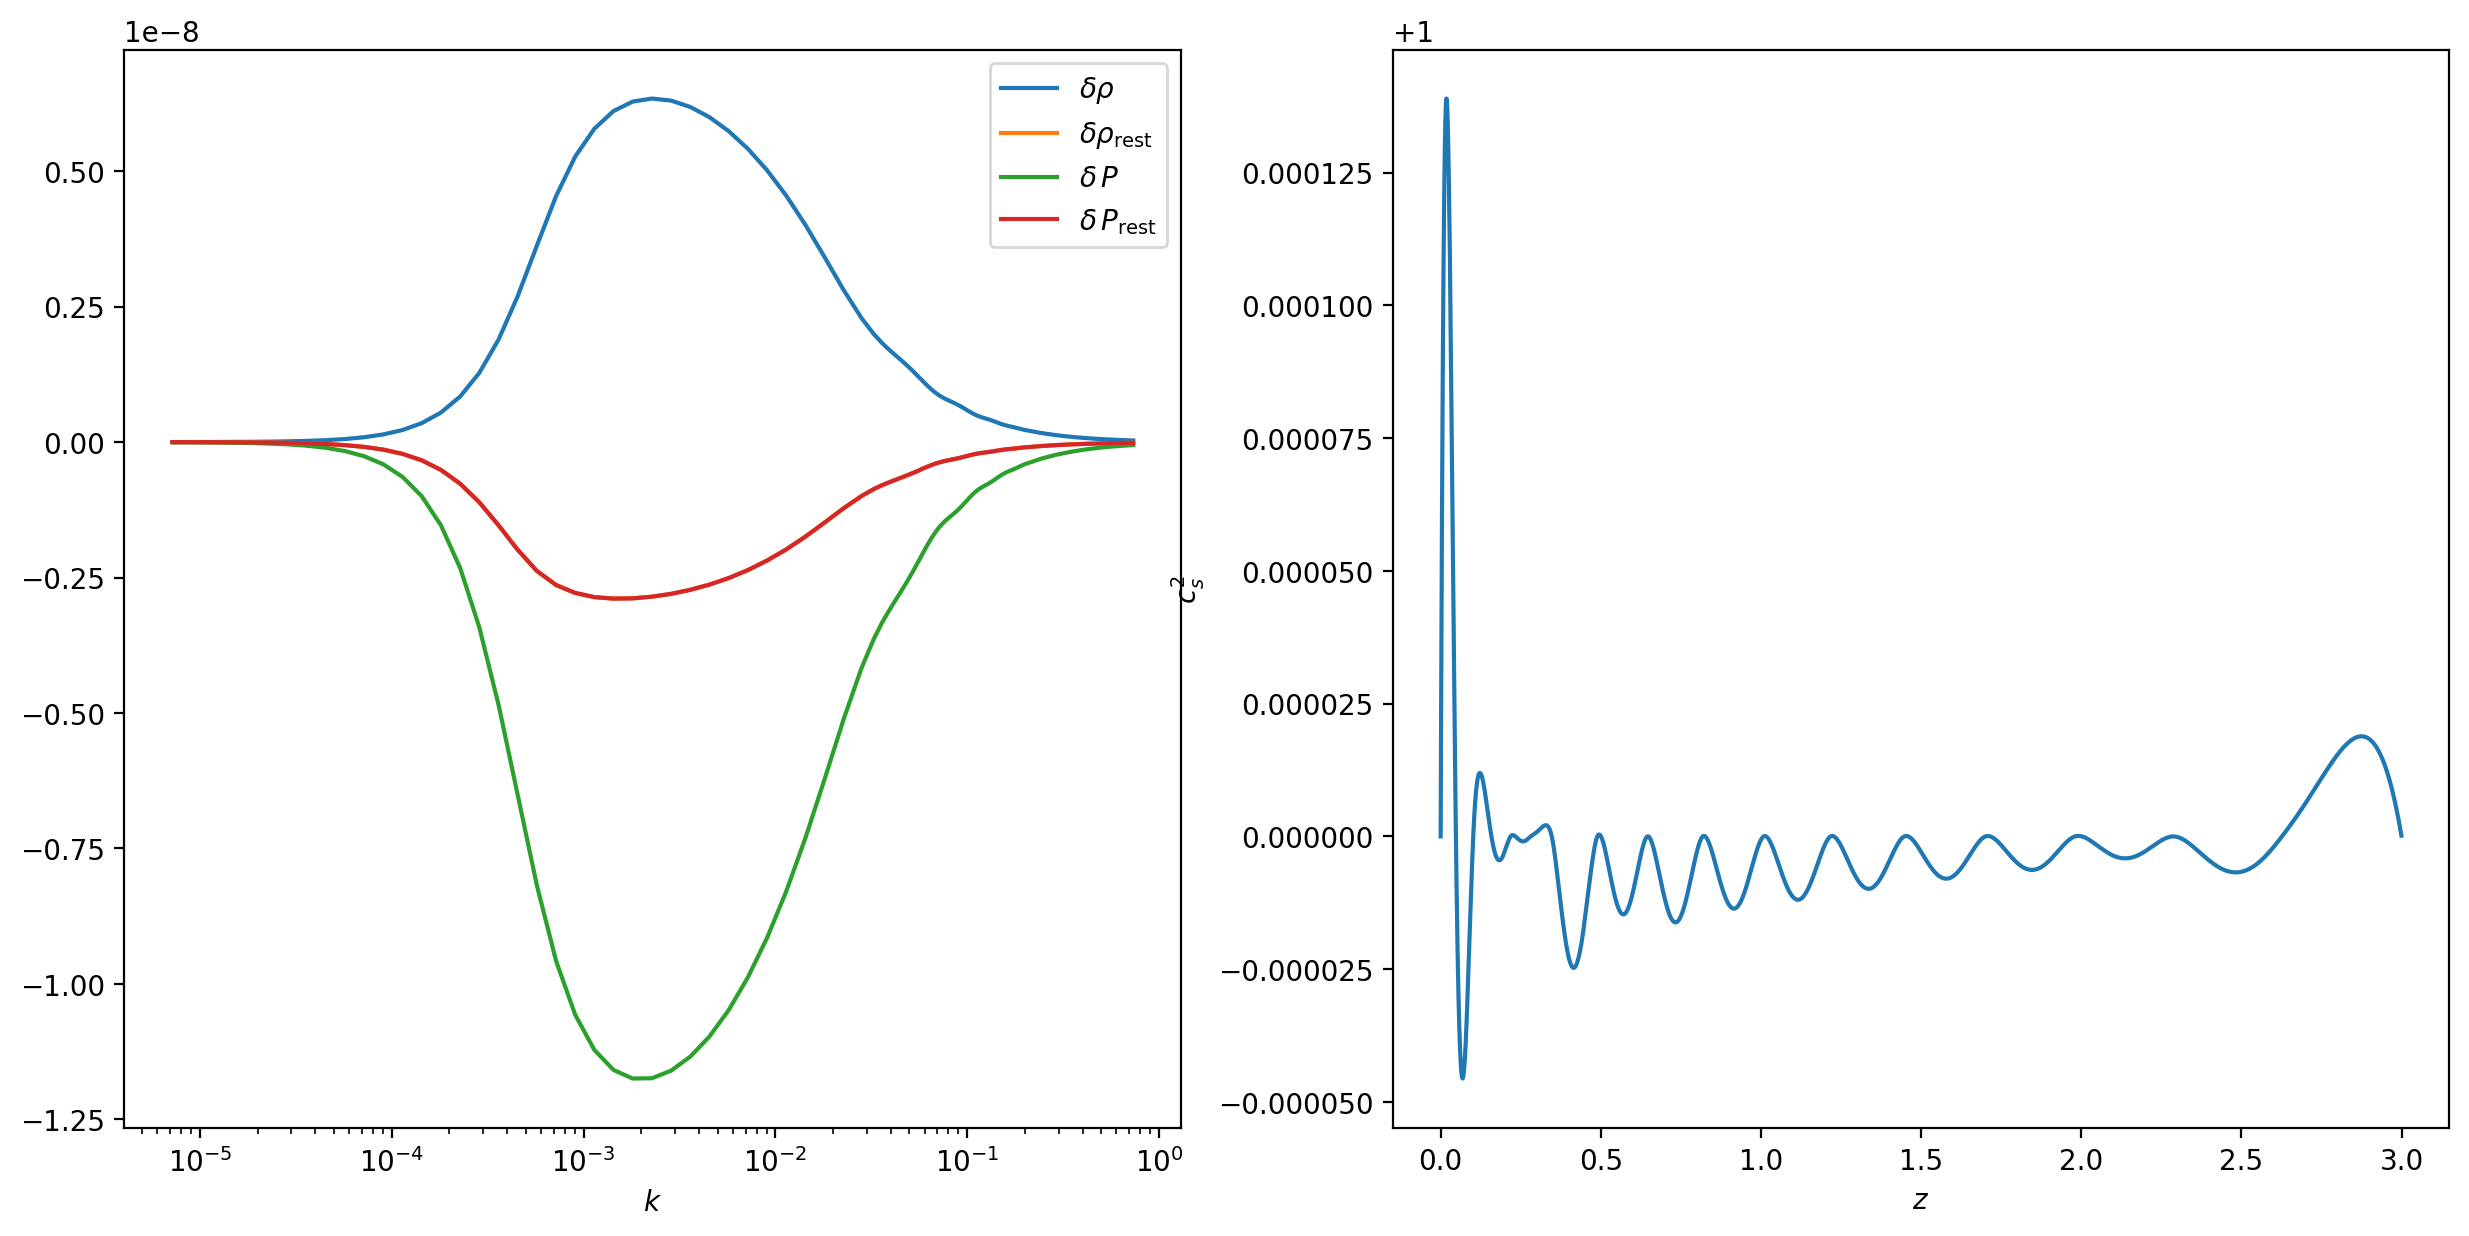

In [18]:
# Get c_s^2 from transfers alone, check if it corresponds to what we set
def get_cs2_rest(cosmo, w0, wa):
    bg = cosmo.get_background()

    mask = bg['z'] < 3
    z = bg['z'][mask]
    a = 1/(z + 1)
    H = bg['H [1/Mpc]'][mask]
    rho_fld = bg['(.)rho_fld'][mask]
    w = w0 + wa*(1-a)
    ca2 = w + a*wa/(1 + w)/3
    
    cs2_rest = []
    for z_, a_, H_, w_, ca2_, rho_fld_ in zip(z, a, H, w, ca2, rho_fld):
        transfers = cosmo.get_transfer(z_)
        k         = transfers['k (h/Mpc)']*cosmo.h() # Convert from h/Mpc to 1/Mpc
        d_rho_fld = transfers['d_rho_fld']
        d_p_fld   = transfers['d_p_fld']
        d_fld     = transfers['d_fld']
        t_fld     = transfers['t_fld']

        d_fld_rest = d_fld + 3*a_*H_*(1 + w_)*t_fld/k**2
        d_rho_fld_rest = rho_fld_*d_fld_rest
        p_gamma    = d_p_fld - ca2_*d_rho_fld

        d_p_fld_rest = p_gamma + ca2_*rho_fld_*d_fld_rest
        cs2_rest_at_z = d_p_fld_rest / d_rho_fld_rest
        cs2_rest.append(cs2_rest_at_z)
    
    # cs2_rest has shape len(k) x len(z)
    # Let's ensure cs2_rest is independent of k
    cs2_rest = np.array(cs2_rest).T
    def all_rows_equal(a: np.array):
        first = a[0]
        for row in a[1:]:
            if not np.allclose(row, first, rtol=0, atol=1e-3): return False
        return True
    
    if not all_rows_equal(cs2_rest): print("WARNING: cs2 is not scale-independent")
    return cs2_rest[0], z, k, d_rho_fld, d_rho_fld_rest, d_p_fld, d_p_fld_rest

cs2_rest, z, k, d_rho_fld, d_rho_fld_rest, d_p_fld, d_p_fld_rest = get_cs2_rest(cosmo_var3, -0.8, -0.1)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].semilogx(k, d_rho_fld, label=r"$\delta\rho$")
axs[0].semilogx(k, d_rho_fld_rest, label=r"$\delta\rho_\mathrm{rest}$")
axs[0].semilogx(k, d_p_fld, label=r"$\delta \, P$")
axs[0].semilogx(k, d_p_fld_rest, label=r"$\delta \, P_\mathrm{rest}$")
axs[0].legend()
axs[1].plot(z, cs2_rest)
axs[1].set_ylabel(r"$c_s^2$")
axs[0].set_xlabel(r"$k$")
axs[1].set_xlabel(r"$z$")

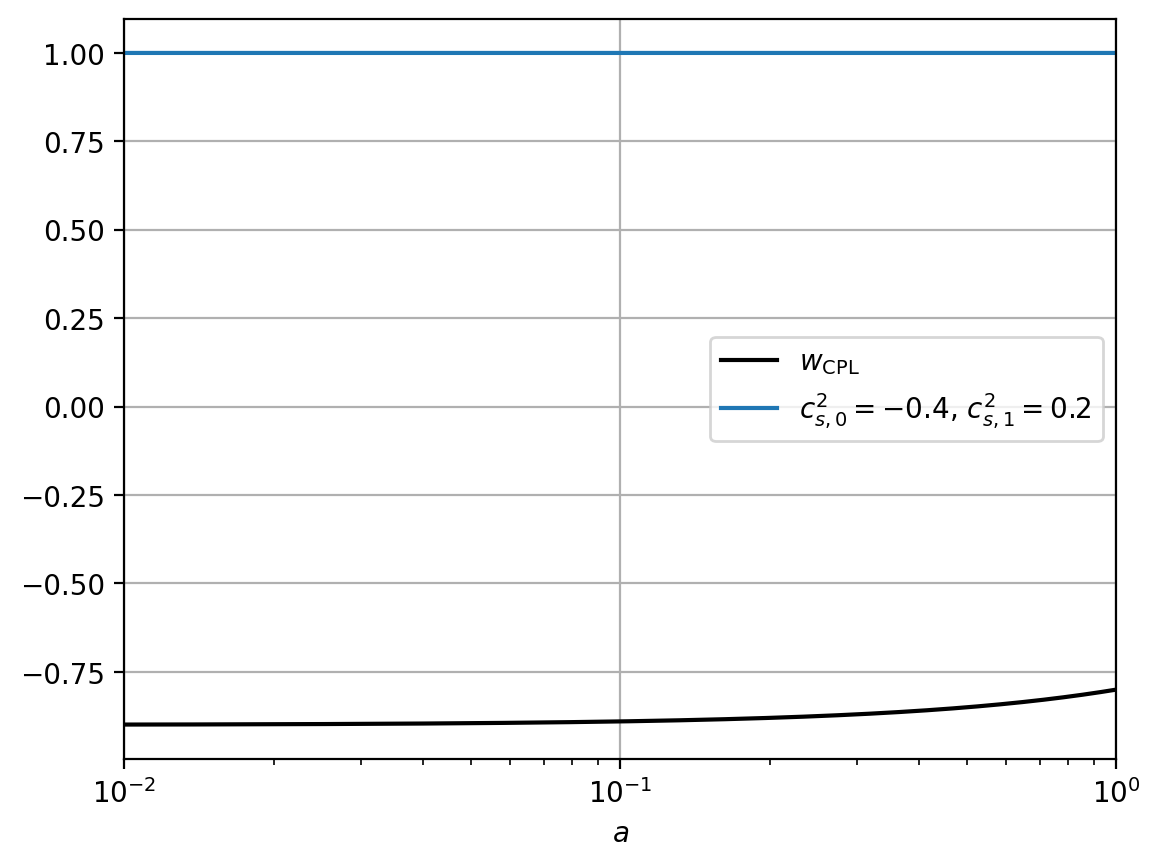

In [19]:
plt.semilogx(a, bg_var3['(.)w_fld'], color='k', label=r"$w_\mathrm{CPL}$")
plt.semilogx(a, bg_var3['cs2_fld'], label=r"$c^2_{s,0} = -0.4$, $c^2_{s,1} = 0.2$")

plt.xlim(1e-2, 1)
plt.xlabel(r"$a$")
plt.legend()
plt.grid()

## Reproducing Rachel Bean's Plots
https://arxiv.org/pdf/astro-ph/0307100

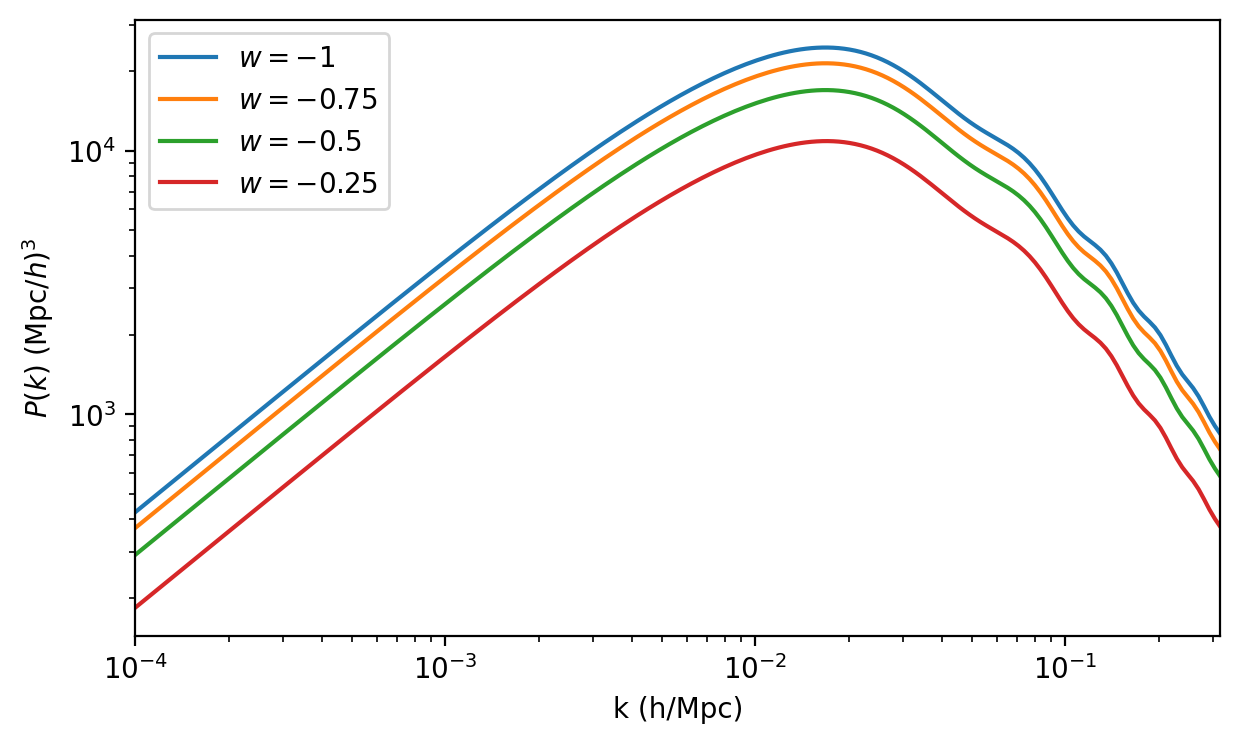

In [15]:
kk = np.logspace(-4, -0.5, 200)
plt.figure(figsize=(7, 4))
for w in [-1, -0.75, -0.5, -0.25]:
  cosmo = Class()
  w_vals = w*np.ones_like(wlog10a_vals)
  params = {
      'output':'mPk',
      'h': h_ref,
      'Omega_b':Ob_ref,
      'Omega_cdm': Om_ref - Ob_ref,
      'A_s':As_ref,
      'n_s':ns_ref,
      'evolver': 0,
  }
  if w != -1:
    params.update({
      'Omega_Lambda': 0,
      'w0_fld': w,
      'wa_fld': 0,
      'cs2_fld_0': 0.0,
      'cs2_fld_1': 0.0,
      'use_ppf': 'no',
    })
  cosmo.set(params)
  cosmo.compute()
  bg = cosmo.get_background()
  Pk  = np.array([pk_h_Mpc_inv(cosmo, k, 0) for k in kk])
  plt.loglog(kk, Pk, label=rf"$w = {w}$")
plt.xlim(kk[0], kk[-1])
plt.xlabel("k (h/Mpc)")
plt.ylabel(r"$P(k) \; (\mathrm{Mpc}/h)^3$")
plt.legend()